# DEM differencing functions

In [132]:
import numpy as np
import osgeo
import rasterio
from rasterio.coords import BoundingBox
from rasterio.mask import mask

import pandas as pd
import geopandas as gpd
import math

from pathlib import Path
import matplotlib.pyplot as plt

import os

from osgeo import gdal, gdalconst
gdal.UseExceptions()

#For zonal stats
from rasterio.features import rasterize
from rasterstats import zonal_stats

# For spatial semivariogram
from pyinterpolate import read_txt
from pyinterpolate import build_experimental_variogram
from pyinterpolate import TheoreticalVariogram, build_theoretical_variogram

# For resample
from rasterio.enums import Resampling

In [14]:
def DEM_difference(dem1, dem2, dod):
    '''
    Use rasterio to subtract dem1 from dem2 and write output to a new geotiff (dod)
    
    dem1: Path object to DEM1
    dem2: Path object to DEM2
    dod: Path object to output DoD
    '''
    #DEM difference
    #with ChatGPT assitance
    # Open the input raster files using rasterio's context manager
    with rasterio.open(dem1) as dataset1, rasterio.open(dem2) as dataset2:
        # Read the raster data as NumPy arrays
        raster_data1 = dataset1.read(1)
        raster_data2 = dataset2.read(1)
    
        # Retrieve the affine transformation matrices
        transform1 = dataset1.transform
        transform2 = dataset2.transform
    
        # Determine the common extent
        bounds1 = dataset1.bounds
        bounds2 = dataset2.bounds
        intersection_bounds = BoundingBox(
            max(bounds1.left, bounds2.left),
            max(bounds1.bottom, bounds2.bottom),
            min(bounds1.right, bounds2.right),
            min(bounds1.top, bounds2.top)
            )
    
       # Update the transformation matrices to the common extent
        window1 = dataset1.window(*intersection_bounds)
        window2 = dataset2.window(*intersection_bounds)
        transform1 = rasterio.windows.transform(window1, transform1)
        transform2 = rasterio.windows.transform(window2, transform2)
    
        # Read the subset of raster data within the common extent
        raster_data1 = dataset1.read(1, window=window1)
        raster_data2 = dataset2.read(1, window=window2)
    
        # Compute the difference between the two rasters
        difference = raster_data2 - raster_data1
        
        # Set nodata values in the difference array
        nodata_mask = np.logical_or(raster_data1 == dataset1.nodata, raster_data2 == dataset2.nodata)
        difference[nodata_mask] = dataset1.nodata
    
        # Retrieve the metadata from one of the input rasters
        metadata = dataset1.meta
    
        # Update the metadata to reflect the difference raster
        metadata.update(
            count=1,
            height=difference.shape[0],
            width=difference.shape[1],
            transform=transform1,
            nodata=dataset1.nodata
        )
    
        # Create a new raster file for the difference
        output_file = dod
        with rasterio.open(str(output_file), 'w', **metadata) as output_dataset:
            output_dataset.write(difference, 1)
    
    print(f"Raster difference complete.\n\nPerformed the following operation:\n\n        {dem2.name} - {dem1.name} = {dod.name}\n\nOutput written to {dod}")

In [71]:
def clip_raster(unclipped_raster, clip_shapefile, out_raster):
    '''
    Use rasterio to clip a raster using a shapefile
    
    unclipped_raster: Path object to raster
    clip_shapefile: Path object to clipping shapefile
    out_raster: Path object to output clipped raster (geotiff, .tif)
    '''
    
    # Read the shapefile using geopandas
    shapefile = gpd.read_file(clip_shapefile)
    
    # Read the raster using rasterio
    with rasterio.open(unclipped_raster) as src:
        # Clip the raster using the shapefile geometry
        clipped_raster, clipped_transform = mask(src, shapefile.geometry, crop=True)
        clipped_meta = src.meta
    
    # Update the metadata of the clipped raster
    clipped_meta.update({
        'height': clipped_raster.shape[1],
        'width': clipped_raster.shape[2],
        'transform': clipped_transform
    })
    
    # Write the clipped raster to the output path
    with rasterio.open(out_raster, 'w', **clipped_meta) as dst:
        dst.write(clipped_raster)
        
    print(f'Raster clipping complete.\nClipped raster saved to: {out_raster}')

In [16]:
def calculate_volume(dod):
    '''
    Report volume, gets cell size from raster metadata

    dod: Path object to DoD
    '''
    #Calc sum
    with rasterio.open(dod) as src:
        # Read the raster data as NumPy arrays
        masked_raster = src.read(1, masked=True)
        #get cell size x, y
        cellsize_x, cellsize_y  = src.res
        #calc vol, area    
        vol = np.sum(masked_raster) * cellsize_x * cellsize_y
        area = masked_raster.count() * cellsize_x * cellsize_y
        #report
        print(f'Volume: {vol} m^3\nArea: {area} m^2\nNumber of cells: {masked_raster.count()}\nCell size X: {cellsize_x}\nCell size Y: {cellsize_y}')

In [31]:
def integer_align_raster(inras, outras):
    '''
    Align raster to integer bounds.
    from gis.stackexchange.com/questions/296770/aligning-many-rasters-using-pyqgis-or-python

    inras: Path object to input raster
    outras: Path object to output raster
    '''
    src = gdal.Open(str(inras), gdalconst.GA_ReadOnly)
    dest = gdal.Open(str(inras), gdalconst.GA_ReadOnly)
    srcProj = src.GetProjection()
    ulx, xres, xskew, uly, yskew, yres  = src.GetGeoTransform()
    lrx = ulx + (src.RasterXSize * xres)
    lry = uly + (src.RasterYSize * yres)
    #get target bounds (expanded to nearest integer
    t_ulx = math.floor(ulx)
    t_uly = math.ceil(uly)
    t_lrx = math.ceil(lrx)
    t_lry = math.floor(lry)
    #gdalwarp
    ds = gdal.Warp(str(outras), src, format='GTiff', outputBounds=[t_ulx, t_lry, t_lrx, t_uly], resampleAlg=gdal.GRA_Bilinear, creationOptions=['COMPRESS=LZW'])

    print(f'Alignment complete.\nInteger aligned raster written to: {outras}')
  

In [93]:
def stable_area_stats(raster, polyshp, add_to_attribute_table : bool =False):
    '''
    Calculate zonal statstics for a polygon shapefile,
    and optionally add them as attributes to attribute table.
    Use this to evaluate systematic and random error for stable areas 
    in DEM of difference.

    raster: Path object to raster
    polyshp: Path object to polygon shapefile
    add_to_attribute_table: boolean to add statistics to attribute table (default False)

    df: dataframe with zonal stats
    '''

    #define MAE function to be added to rasterstats
    def mae(x):
        return np.ma.mean(np.abs(x))

    # Read the shapefile using geopandas
    shapefile = gpd.read_file(polyshp)
    
    # Read the raster using rasterio
    with rasterio.open(raster) as src:
        # Get the raster values as a numpy array
        raster_values = src.read(1)
        # Get the affine transformation from the raster
        transform = src.transform
        # Perform the zonal statistics using rasterstats
        stats = zonal_stats(shapefile, raster_values, affine=transform, nodata=src.nodata, stats=['mean', 'max', 'min', 'std', 'sum'], add_stats={'mae':mae})
    
    # Extract the statistics and add them as new attributes in the shapefile
    shapefile['raster'] = raster.name
    shapefile['mean'] = [stat['mean'] for stat in stats]
    shapefile['max'] = [stat['max'] for stat in stats]
    shapefile['min'] = [stat['min'] for stat in stats]
    shapefile['std'] = [stat['std'] for stat in stats]
    shapefile['sum'] = [stat['sum'] for stat in stats]
    shapefile['mae'] = [stat['mae'] for stat in stats]

    df = shapefile[['id','mean','max','min','std','sum','mae']]
       
    if add_to_attribute_table:
        # Save attributes to the updated shapefile
        shapefile.to_file(polyshp)

    #print stats
    print('Zonal statistics calculation complete.\n')
    print(df)

    return df

In [119]:
def vertical_adjust_raster(input_raster, adjustment_value, output_raster):
    '''
    Use this function to vertically adjust a raster. Value provided in argument will be added to input raster
    and saved to output raster.  Rasters must be geotiff.

    input_raster: Path object to input raster
    adjustment_value: floating point value that will be added to input_raster to create output_raster
    output_raster: Path object to adjusted output raster
    '''

    # Read the raster using rasterio
    with rasterio.open(input_raster) as src:
        # Get the raster values as a masked numpy array
        raster_values = src.read(1,masked=True)
        src_meta = src.meta

    # Add value
    out_raster_values = raster_values + adjustment_value

    #Write new raster with same meta
    with rasterio.open(output_raster, 'w', **src_meta) as dst:
        # Get the raster values as a numpy array
        dst.write(out_raster_values, indexes=1)


In [151]:
def resample_raster_bilinear(input_raster, new_cell_size, output_raster):
    '''
    Use this function to resample a raster using bilinear interpolation. Value provided in argument 
    will be new cell size for output raster.  Rasters must be geotiff.

    input_raster: Path object to input raster
    new_cell_size: floating point value for cell size of new raster
    output_raster: Path object to resampled output raster
    '''
    # Read the raster using rasterio
    with rasterio.open(input_raster) as src:
        # Get the raster values as a masked numpy array
        # raster_values = src.read(1,masked=True)
        profile = src.profile.copy()
        #get cell size x, y
        cellsize_x, cellsize_y  = src.res

        #determine scale factor
        scale_factor = cellsize_x/new_cell_size

        # resample data to target shape
        data = src.read(
                            out_shape=(
                                src.count,
                                int(src.height * scale_factor),
                                int(src.width * scale_factor)
                                ),
                                resampling=Resampling.bilinear
                            )
    
        # scale image transform
        transform = src.transform * src.transform.scale(
                                                        (src.width / data.shape[-1]),
                                                        (src.height / data.shape[-2])
                                                    )

        profile.update({"height": data.shape[-2],
                    "width": data.shape[-1],
                   "transform": transform})

    with rasterio.open(output_raster, "w", **profile) as dataset:
        dataset.write(data)


In [43]:
def SpatiallyCorrelatedRandomErrorAnalysis_DataPrep(raster, polyshp, poly_id_field='id', poly_id=1):
    '''
    Use this function to select a portion of the raster on which to perform the analysis
    to determine spatially correlated random error. 
    This function will clip a raster using a shapefile and return a dataframe with x,y,z values 
    for subsequent semi-variogram analysis.

    raster: Path object to input raster
    polyshp: Path object to polygon shapefile with polygon for stable area
    poly_id_field: name of field in attribute table used to select polygon (str)
    poly_id: polygon ID to select single polygon for analysis (to select from poly_id_field).

    '''

    # Read the polygon shapefile using geopandas
    polygon_gdf = gpd.read_file(polyshp)
    # select only one polygon
    polygon_gdf = polygon_gdf.loc[polygon_gdf[poly_id_field] == poly_id]
    
    # Read the raster using rasterio
    with rasterio.open(raster) as src:
        # Clip the raster using the shapefile geometry
        clipped_raster, clipped_transform = rasterio.mask.mask(src, polygon_gdf.geometry, crop=True)
        clipped_meta = src.meta
    
    # Update the metadata of the clipped raster
    clipped_meta.update({
        'height': clipped_raster.shape[1],
        'width': clipped_raster.shape[2],
        'transform': clipped_transform
    })
    
    # Extract the x, y coordinates from the transform
    x_coords = []
    y_coords = []
    z_values = []
    
    for row in range(clipped_raster.shape[1]):
        for col in range(clipped_raster.shape[2]):
            x, y = rasterio.transform.xy(clipped_transform, row, col)
            value = clipped_raster[0, row, col]  # Assume single-band raster
    
            if value != clipped_meta['nodata']:
                x_coords.append(x)
                y_coords.append(y)
                z_values.append(value)
    
    # Create a pandas DataFrame with x, y, z values
    df = pd.DataFrame({'x': x_coords, 'y': y_coords, 'z': z_values})

    return df

In [50]:
def SpatiallyCorrelatedRandomErrorAnalysis_CreateSemivariogram(df, cellsize, max_range=80):
    '''
    Use this function to create and plot a preliminary semivariogram to be used to help estimate 
    the correct range subsequent semivariogram plotting.

    df: dataframe with x,y,z columns
    cellsize: cell size of DEM of difference
    max_range: maximum range for prelim semivariogram (something larger than predicted range, default 80 meters)

    '''
    #Get the semi-variogram values through kriging 
    #(using pyinterpolate library, with help from docs here: 
    # https://pyinterpolate.readthedocs.io/en/latest/usage/tutorials/Semivariogram%20Estimation%20(Basic).html
    
    #sample list
    data = df[['x','y','z']].to_numpy()
    
    # Create experimental semivariogram
    experimental_variogram = build_experimental_variogram(input_array=data, step_size=cellsize, max_range=max_range)
    print('Use this plot to estimate range for subsequent autofit...\n\n')
    experimental_variogram.plot(plot_semivariance=True, plot_covariance=True, plot_variance=True)
    return experimental_variogram

In [64]:
def SpatiallyCorrelatedRandomErrorAnalysis_SphericalModel(experimental_variogram, var_range=40, nugget=0):
    '''
    Use this function to plot a spherical semivariogram.  Must run SpatiallyCorrelatedRandomErrorAnalysis_CreateSemivariogram function first.

    experimental_variogram: variogram object from SpatiallyCorrelatedRandomErrorAnalysis_CreateSemivariogram function
    var_range: range estimated from semivariogram plotted with SpatiallyCorrelatedRandomErrorAnalysis_CreateSemivariogram function
    nugget: nugget, should leave at 0 for this analysis (default: 0 meters)
    '''
    #Use plot from "SpatiallyCorrelatedRandomErrorAnalysis_CreateSemivariogram" function to estimate range
    sill = experimental_variogram.variance
    
    spherical_model = build_theoretical_variogram(experimental_variogram=experimental_variogram,
                                                  model_type='spherical',
                                                  sill=sill,
                                                  rang=var_range,
                                                  nugget=nugget)
    
    print(f'Spherical model RMSE: {spherical_model.rmse}\n\n')
    spherical_model.plot()
    return spherical_model

In [65]:
def SpatiallyCorrelatedRandomErrorAnalysis_OptimizedModel(experimental_variogram, var_range=40, nugget=0):
    '''
    Use this function to plot determine an optimized semivariogram model for the stable areas.  Must run SpatiallyCorrelatedRandomErrorAnalysis_CreateSemivariogram function first.

    experimental_variogram: variogram object from SpatiallyCorrelatedRandomErrorAnalysis_CreateSemivariogram function
    var_range: range estimated from semivariogram plotted with SpatiallyCorrelatedRandomErrorAnalysis_CreateSemivariogram function
    nugget: nugget, should leave at 0 for this analysis (default: 0 meters)
    '''
    #Use plot from "SpatiallyCorrelatedRandomErrorAnalysis_CreateSemivariogram" function to estimate range
    sill = experimental_variogram.variance
    
    semivariogram_model = TheoreticalVariogram()
    fitted = semivariogram_model.autofit(
        experimental_variogram=experimental_variogram,
        model_types='all',
        nugget=0,
        rang=var_range,
        sill=sill)
    print(f"Chosen model type: {fitted['model_type']}\nNugget: {fitted['nugget']}\nSill: {fitted['sill']}\nRange: {fitted['range']}\nRMSE: {fitted['rmse']}")
    
    fitted = semivariogram_model.autofit(experimental_variogram=experimental_variogram, nugget=0)
    print(f"\n\nOptimized model type: {fitted['model_type']}\nNugget: {fitted['nugget']}\nOptimized Sill: {fitted['sill']} (USE THIS VALUE FOR SPATIALLY CORRELATED RANDOM ERROR VOLUMETRIC UNCERTAINTY CALCULATIONS)\nOptimized Range: {fitted['range']} (USE THIS VALUE FOR SPATIALLY CORRELATED RANDOM ERROR VOLUMETRIC UNCERTAINTY CALCULATIONS)\nRMSE: {fitted['rmse']}")
    semivariogram_model.plot()
    return semivariogram_model

In [38]:
# #inputs
# dem1 = Path(r"C:\Users\jlogan\OneDrive - DOI\LRDP\LosPadresRes\bathy\ReprojectedBathyDougSmith\2016_correction\HDR_LP1m_NAD832011_depth_dependent_corrected_v2_integer_aligned.tif")
# dem2 = Path(r"C:\Users\jlogan\OneDrive - DOI\LRDP\LosPadresRes\bathy\ReprojectedBathyDougSmith\2017\lp17cube1m_NAD832011_integer_aligned.tif")
# #out
# outdod = Path(r"C:\Users\jlogan\OneDrive - DOI\LRDP\LosPadresRes\DEM_differencing\DoD\temp_dod.tif")
# outdodclipped = Path(r"C:\Users\jlogan\OneDrive - DOI\LRDP\LosPadresRes\DEM_differencing\DoD\temp_dod_clipped.tif")
# #DoD clip
# clip_shp = Path(r"C:\Users\jlogan\OneDrive - DOI\LRDP\LosPadresRes\DEM_differencing\DoD\shp\2016_hull_poly.shp")

# stable_area_poly = Path(r"C:\Users\jlogan\OneDrive - DOI\LRDP\LosPadresRes\DEM_differencing\DoD\shp\Stable_2017-2016.shp")

In [88]:
df = SpatiallyCorrelatedRandomErrorAnalysis_DataPrep(Path(r"C:\Users\jlogan\OneDrive - DOI\LRDP\LosPadresRes\DEM_differencing\DoD\DoD_2017-HDR_DepCorrV2_script_generated_clipped.tif"), stable_area_poly, poly_id_field='id', poly_id=1)

Use this plot to estimate range for subsequent autofit...


'Warning! Attribute is_variance is set to False but you try to plot this object! Plot has been cancelled.\n'


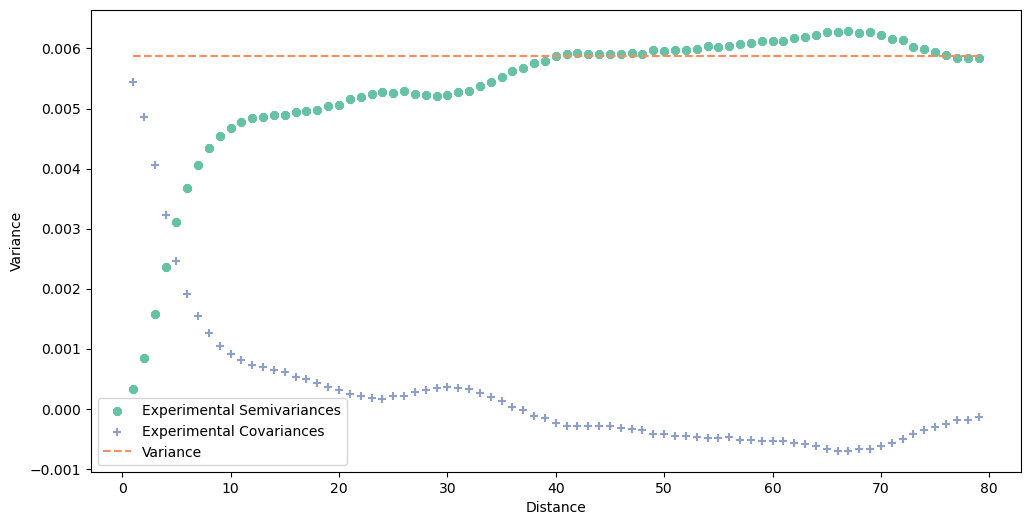

In [49]:
# experimental_variogram = SpatiallyCorrelatedRandomErrorAnalysis_CreateSemivariogram(df,1)

Spherical model RMSE: 0.0009759893574314627




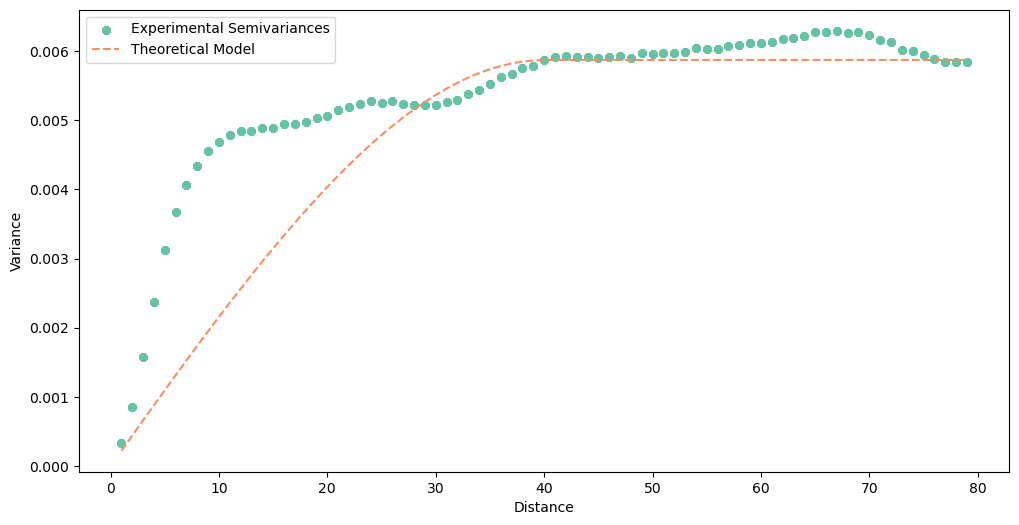

In [67]:
# spherical_model = SpatiallyCorrelatedRandomErrorAnalysis_SphericalModel(experimental_variogram, var_range=40)

Chosen model type: spherical
Nugget: 0
Sill: 0.00587096953275412
Range: 40
RMSE: 0.0009759893574314627


Optimized model type: spherical
Nugget: 0
Optimized Sill: 0.00587096953275412 (USE THIS VALUE FOR SPATIALLY CORRELATED RANDOM ERROR VOLUMETRIC UNCERTAINTY CALCULATIONS)
Optimized Range: 22.287440409342658 (USE THIS VALUE FOR SPATIALLY CORRELATED RANDOM ERROR VOLUMETRIC UNCERTAINTY CALCULATIONS)
RMSE: 0.0005039054855293714


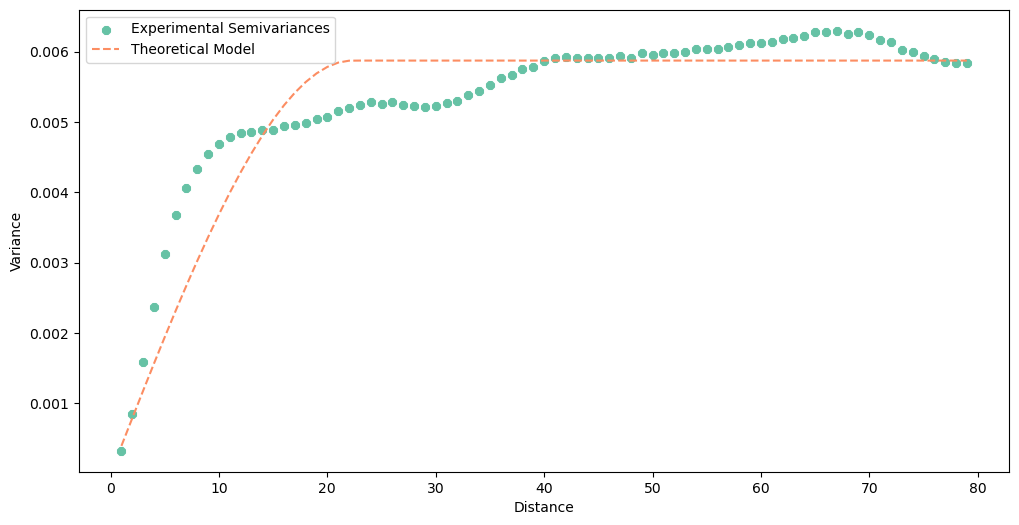

In [69]:
# _ = SpatiallyCorrelatedRandomErrorAnalysis_OptimizedModel(experimental_variogram, var_range=40)

In [28]:
# clip_raster(outdod, clip_shp, outdod_clipped)

Raster clipping complete.
Clipped raster saved to: C:\Users\jlogan\OneDrive - DOI\LRDP\LosPadresRes\DEM_differencing\DoD\temp_dod_clipped.tif


In [29]:
# calculate_volume(outdodclipped)

Volume: 41753.390625 m^3
Area: 161587.0 m^2
Number of cells: 161587
Cell size X: 1.0
Cell size Y: 1.0


In [32]:
# inras = Path(r"C:\Users\jlogan\OneDrive - DOI\LRDP\LosPadresRes\bathy\ReprojectedBathyDougSmith\2017\lp17cube1m_NAD832011.tif")
# outras = Path(r"C:\Users\jlogan\OneDrive - DOI\LRDP\LosPadresRes\bathy\ReprojectedBathyDougSmith\2017\lp17cube1m_NAD832011_integer_aligned_test.tif")

# integer_align_raster(inras,outras)

Alignment complete.
Integer aligned raster written to: C:\Users\jlogan\OneDrive - DOI\LRDP\LosPadresRes\bathy\ReprojectedBathyDougSmith\2017\lp17cube1m_NAD832011_integer_aligned_test.tif


In [94]:
raster = Path(r"C:\Users\jlogan\OneDrive - DOI\LRDP\LosPadresRes\DEM_differencing\DoD\DoD_2017-HDR_DepCorrV2_script_generated_clipped.tif")
polyshp = Path(r"C:\Users\jlogan\OneDrive - DOI\LRDP\LosPadresRes\DEM_differencing\DoD\shp\Stable_2017-2016.shp")

df = stable_area_stats(raster, polyshp)

Zonal statistics calculation complete.

   id      mean       max       min       std         sum       mae
0   1 -0.027426  0.339661 -0.394226  0.076622 -269.103149  0.058917
1   2 -0.076299  0.065735 -0.255280  0.047330 -319.845642  0.077314
2   3  0.005922  0.149048 -0.098450  0.048099    5.389435  0.038864
3   4  0.041908  0.271851 -0.209229  0.094044   28.455475  0.084630
4   1  0.005778  0.339661 -0.626953  0.096911   84.098389  0.072794
